# Testing the Mahalanobis distance-based classifier on the GBM Dataset  
In this notebook, I used the Mahalanobis distance-based classifier—previously trained in `Mahalanobis_training.ipynb` and saved to disk—to analyze the GBM dataset. 

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad

from scipy.spatial.distance import mahalanobis
import scipy.sparse as sp
import numpy.linalg as linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.decomposition import PCA
import joblib
from joblib import Parallel, delayed
import functools
import matplotlib.pyplot as plt

In [2]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(7, 4))
sc.settings.verbosity = 3

-----
anndata     0.10.8
scanpy      1.10.1
-----
PIL                         10.2.0
anyio                       NA
arrow                       1.3.0
asciitree                   NA
asttokens                   NA
astunparse                  1.6.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.11.0
bottleneck                  1.3.7
brotli                      1.0.9
certifi                     2024.08.30
cffi                        1.16.0
charset_normalizer          2.0.4
cloudpickle                 3.0.0
colorama                    0.4.6
comm                        0.2.1
cycler                      0.10.0
cython_runtime              NA
dask                        2024.7.0
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
defusedxml                  0.7.1
executing                   0.8.3
fastjsonschema              NA
fqdn                        NA
h5py                        3.9.0
id

#### Importing all required resources: the test dataset, the previously selected genes, and the model (means, covariances) with the useful components (pca, scaler).

In [3]:
test = sc.read_h5ad(
    '/hpc/hers_basak/rnaseq_data/Silettilab/proj/GBM/output/data/GBM_Tumor_Dissociation.h5ad')

In [4]:
selectedGenes = np.loadtxt(
    '/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/final_useful_datasets/MD_selected_genes.txt', 
    dtype=str)

In [5]:
scaler = joblib.load('/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/final_useful_datasets/models/MD_scaler.joblib')
pca = joblib.load( '/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/final_useful_datasets/models/MD_pca.joblib')

In [6]:
means = joblib.load('/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/final_useful_datasets/models/MD_means.joblib')
covariances = joblib.load('/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/final_useful_datasets/models/MD_covariances.joblib')

## Step 1: Initial adjustments

#### I updated the index of `test.var` by replacing ensemble IDs with gene names, and filtered it to include only the genes selected in the training notebook.

In [7]:
test.var = (
    test.var
    .reset_index()                      
    .rename(columns={'index': 'ensemble_ids'})  
    .set_index('Gene')                  
)

test.var.index = test.var.index.astype(str)
test.var_names_make_unique(join="_")
test = test[:, selectedGenes]

/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['marker-DsRed', 'marker-Cherry', 'marker-GFP', 'marker-Tomato', 'marker-cre']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


## Step 2: testing of the model

#### Normalization by row and logarithmization.

In [8]:
sc.pp.normalize_total(test, target_sum=1e4)
sc.pp.log1p(test)

/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


In [9]:
test_X_dense = test.X.toarray()
test_scaled = scaler.transform(test_X_dense)

#### I applied the scaler (normalization by column) and the PCA model, both of which were trained on the training dataset and imported earlier. 
By using `pca.transform(test_scaled)`, I am projecting the cell data into the subspace defined by the PCA training dataset. This step reduces the number of dimensions, simplifying the computation.

In [10]:
test_pca = pca.transform(test_scaled)
test.obsm['X_pca'] = test_pca

In [11]:
test_pca

array([[-1.57350132,  1.32646593,  0.40339202, ...,  7.63938269,
        -3.02196529,  2.8839849 ],
       [-1.96364613,  0.45425814,  0.34481784, ...,  5.9540549 ,
        -1.92319846,  2.85032717],
       [-0.94023669,  1.01187006,  0.60696002, ...,  4.09116766,
        -1.03337547,  1.64729666],
       ...,
       [-2.82926487, -1.18579552, -1.34026335, ..., -3.39330625,
        -0.21484418, -2.15348022],
       [-7.20583112, -6.41916575, -5.49050263, ..., -0.14864445,
        -0.84810686, -0.92657364],
       [-8.35149273, -6.98549779, -3.25361726, ...,  1.31845128,
        -2.07345562, -1.85442381]])

#### Function to classify one tumor cell
For a given cell this function computes the Mahalanobis distance relative to the mean of each cell type. Then, it converts these distances into affinity scores by applying an exponential to the negative distance (optionally scaled) and normalizes the scores using softmax to obtain probabilities.

Returns:
  - **best_match**: the cell type with the highest normalized probability.
  - **best_probability**: the probability associated with the best_match.
  - **min_distance**: the minimum distance (corresponding to the best_match).
  - **distances**: a dictionary mapping each cell type to its Mahalanobis distance.
  - **probabilities**: a dictionary mapping each cell type to its softmax-normalized probability.

In [12]:
def classify_single_cell(cell, means, covariances, scale=1.0):

    distances = {}
    affinities = {}
    
    # Calculate distances and convert them into affinity scores for each cell class.
    for cell_type, mean in means.items():
        inv_cov = linalg.pinv(covariances[cell_type])
        d = mahalanobis(cell, mean, inv_cov)
        distances[cell_type] = d
        # Affinity score calculated as the exponential of the negative distance (scaled). Save all the info for all classes.
        affinities[cell_type] = np.exp(-scale * d)
    
    # Softmax normalization: each probability for each class is given by the affinity divided by the total sum of affinities
    total_affinity = sum(affinities.values())
    probabilities = {ct: aff / total_affinity for ct, aff in affinities.items()}
    
    # The best_match is the cell type with the highest probability (corresponds to the minimum distance)
    best_match = max(probabilities, key=probabilities.get)
    best_probability = probabilities[best_match]
    min_distance = distances[best_match]
    
    return best_match, best_probability, min_distance, distances, probabilities

#### Function to apply the previous function `classify_single_cell()` to all cells
Classify tumor cells in batches to handle large datasets.

In [13]:
def classify_tumor_cells(tumor_pca_data, means, covariances, scale=1.0):
    # Determine the total number of tumor cells to classify.
    total_cells = len(tumor_pca_data)
    print(f"Total number of tumor cells to classify: {total_cells}")

    # Set the block size and compute the number of blocks needed.
    block_size = 1000
    num_blocks = (total_cells + block_size - 1) // block_size

    # Initialize lists to accumulate results from each block.
    classifications = []
    best_probabilities = []
    min_distances = []
    all_distances = []
    all_probabilities = []

    # Process cells in blocks to efficiently handle large datasets.
    for i in range(num_blocks):
        # Define the start and end indices for the current block.
        start = i * block_size
        end = min(start + block_size, total_cells)
        print(f"Processing block {i + 1}/{num_blocks} cells from {start + 1} to {end}.")

        # Classify each cell in the current block using parallel processing.
        block_results = Parallel(n_jobs=-1)(
            delayed(classify_single_cell)(cell, means, covariances, scale)
            for cell in tumor_pca_data[start:end]
        )

        # Unpack the results from the block into separate variables.
        (block_classifications, block_best_probabilities, block_min_distances,
         block_all_distances, block_all_probabilities) = zip(*block_results)

        # Append the current block's results to the overall lists.
        classifications.extend(block_classifications)
        best_probabilities.extend(block_best_probabilities)
        min_distances.extend(block_min_distances)
        all_distances.extend(block_all_distances)
        all_probabilities.extend(block_all_probabilities)

    # Signal the completion of the classification process.
    print("Classification complete.")
    return classifications, best_probabilities, min_distances, all_distances, all_probabilities

#### Apply the function to the GBM test dataset

In [14]:
tumor_classifications, tumor_best_probabilities, tumor_min_distances, tumor_all_distances, tumor_all_probabilities = classify_tumor_cells(
    test.obsm['X_pca'], means, covariances, scale=0.4
)

Total number of tumor cells to classify: 332357
Processing block 1/333 cells from 1 to 1000.
Processing block 2/333 cells from 1001 to 2000.
Processing block 3/333 cells from 2001 to 3000.
Processing block 4/333 cells from 3001 to 4000.
Processing block 5/333 cells from 4001 to 5000.
Processing block 6/333 cells from 5001 to 6000.
Processing block 7/333 cells from 6001 to 7000.
Processing block 8/333 cells from 7001 to 8000.
Processing block 9/333 cells from 8001 to 9000.
Processing block 10/333 cells from 9001 to 10000.
Processing block 11/333 cells from 10001 to 11000.
Processing block 12/333 cells from 11001 to 12000.
Processing block 13/333 cells from 12001 to 13000.
Processing block 14/333 cells from 13001 to 14000.
Processing block 15/333 cells from 14001 to 15000.
Processing block 16/333 cells from 15001 to 16000.
Processing block 17/333 cells from 16001 to 17000.
Processing block 18/333 cells from 17001 to 18000.
Processing block 19/333 cells from 18001 to 19000.
Processing blo

In [15]:
expected_classes = set(tumor_classifications)

#### I saved the predictions into the original test anndata object.

In [16]:
test.obs['predictions_MD'] = tumor_classifications
test.obs['max_probability_MD'] = tumor_best_probabilities
test.obs['all_distances_MD'] = tumor_all_distances
test.obs['all_probabilities_MD'] = tumor_all_probabilities
test.obs['min_distance_MD'] = tumor_min_distances

#### I saved the predictions into a dataframe.

In [17]:
#test.obs[['predictions_MD', 'max_probability_MD', 'min_distance_MD', 'all_distances_MD', 'all_probabilities_MD']].to_csv('/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/final_useful_datasets/mahalanobis_predictions.csv')

## Step 4: evaluation of the results.

#### This code creates a grid of UMAP scatter plots where each subplot highlights cells predicted as a specific expected class against a light gray background of all cells. It then hides any unused subplots, adds a legend to the figure, adjusts the layout, and displays the final plot.

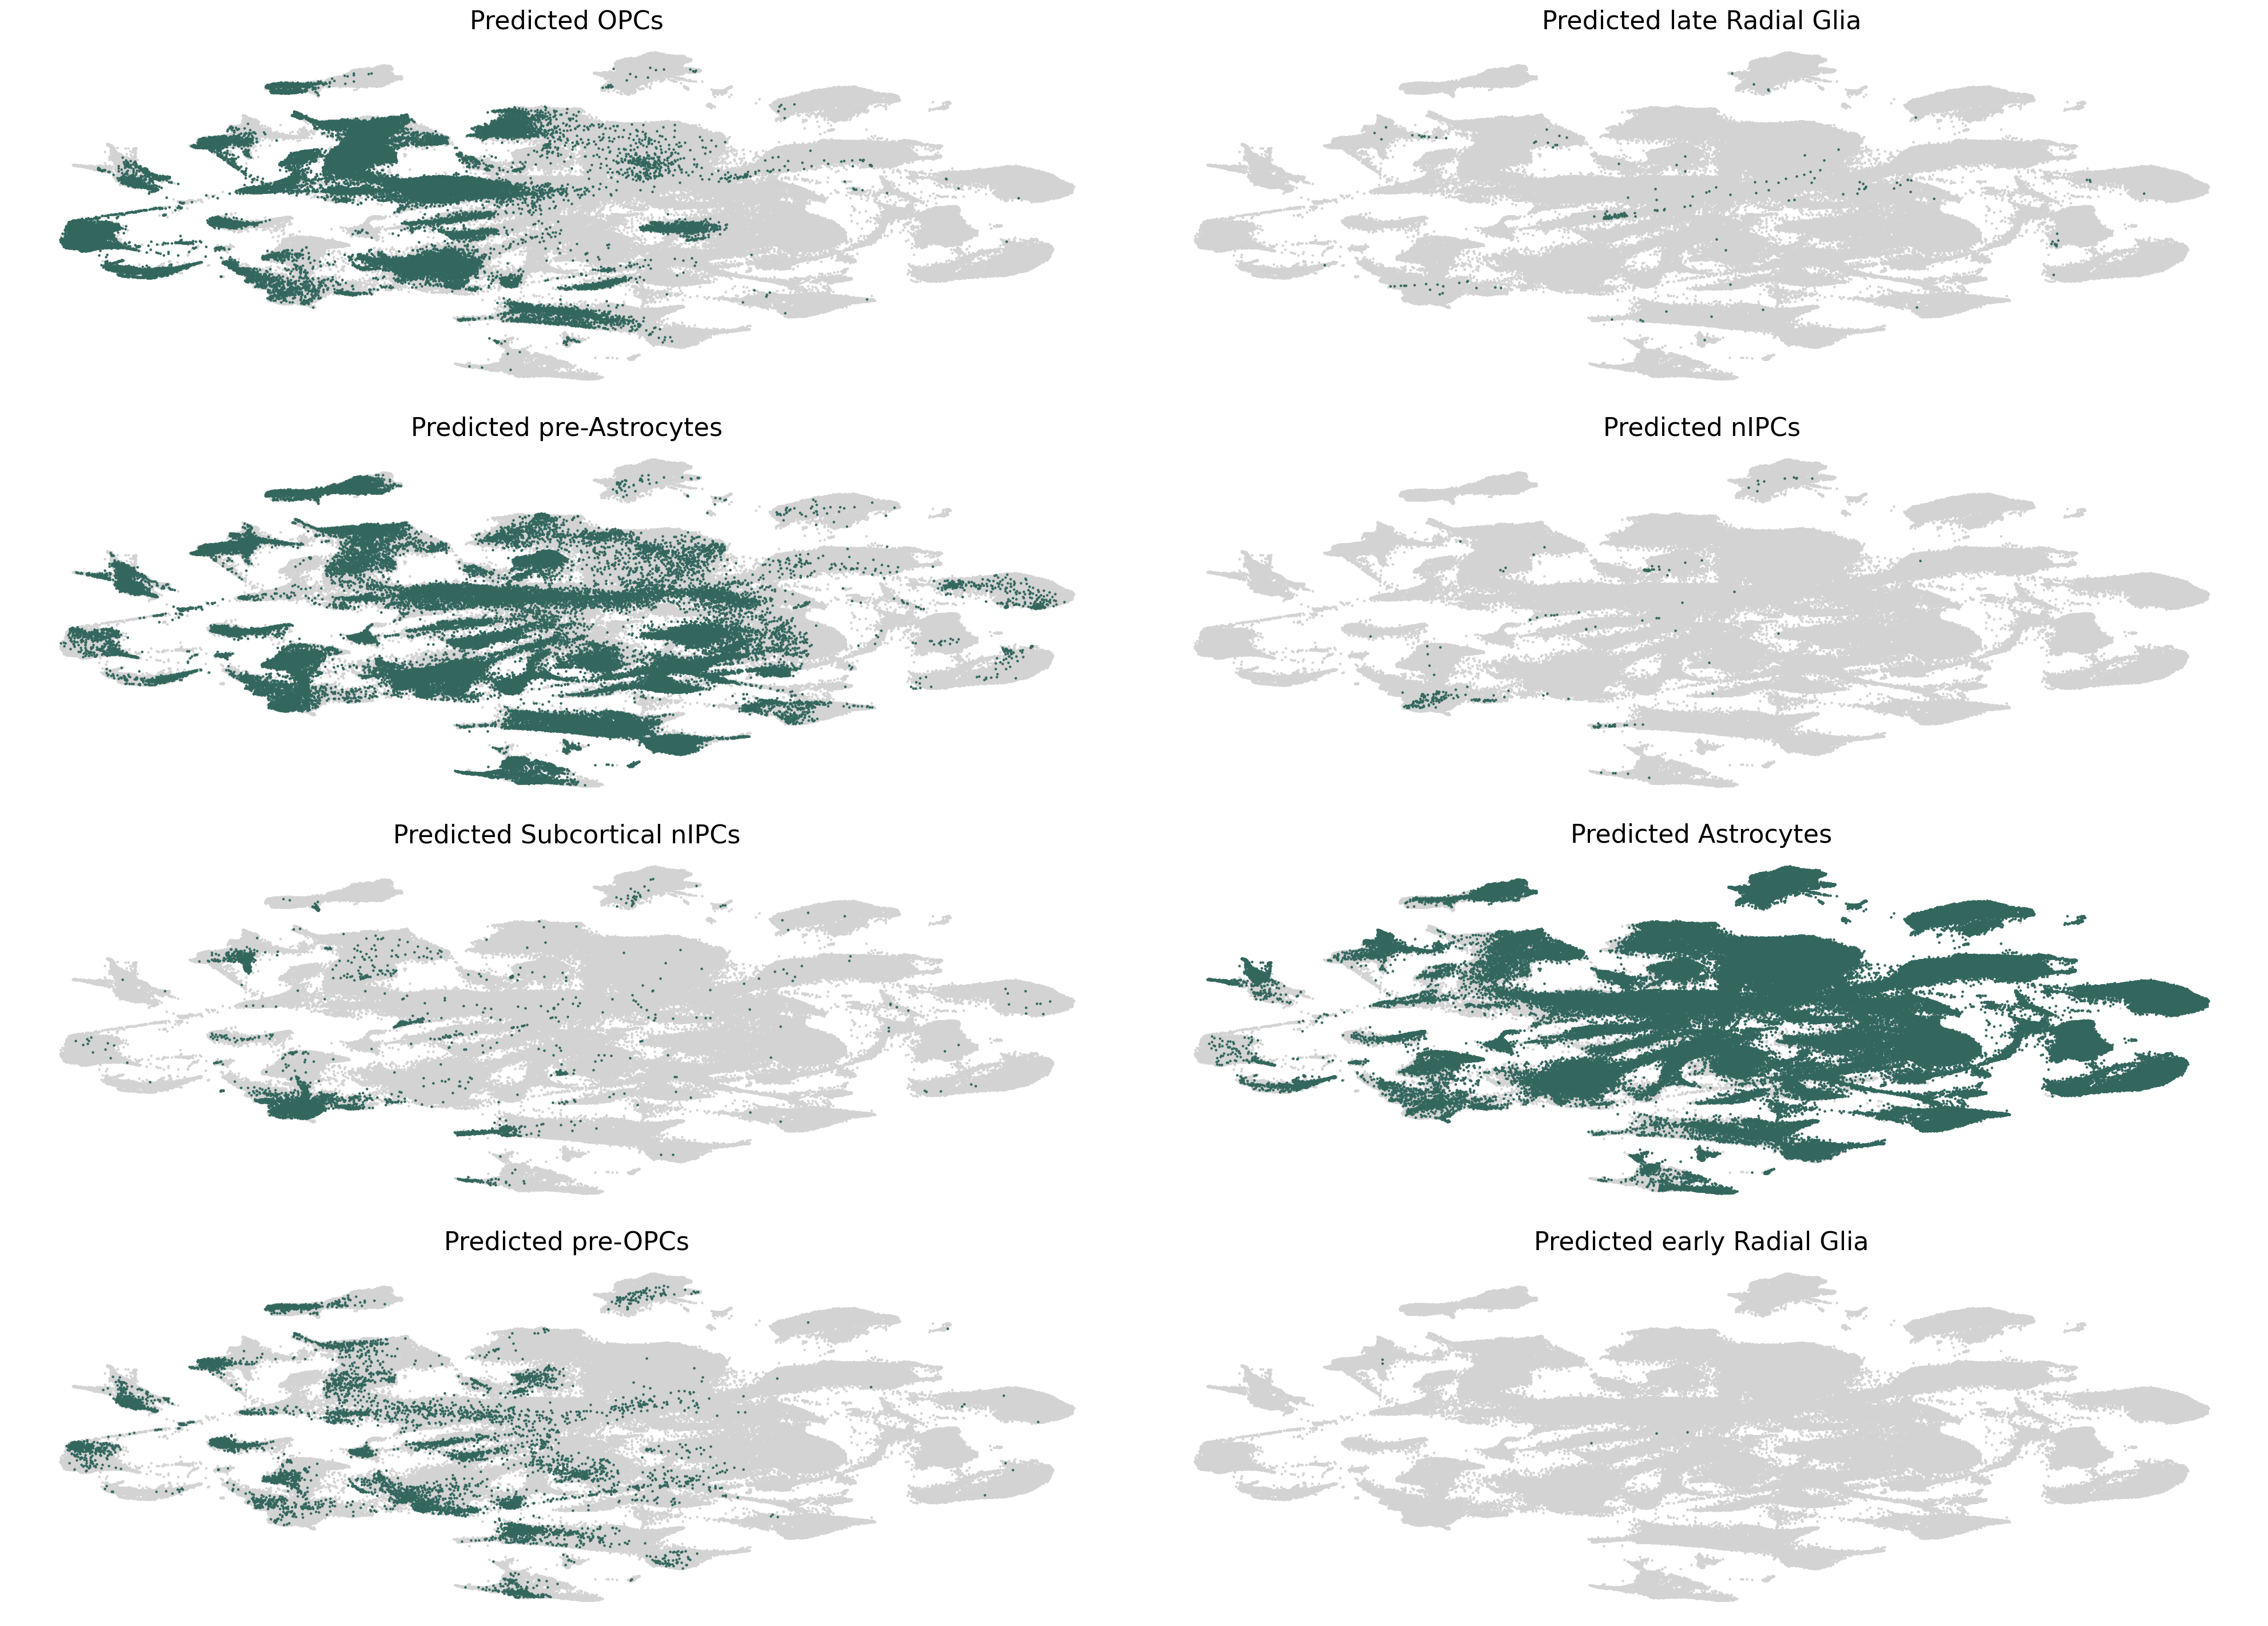

In [20]:
unique_predictions = test.obs['predictions_MD'].unique()
n_rows = (len(expected_classes) + 1) // 2
n_cols = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(25, 18))
axs = axs.flatten()

for i, prediction in enumerate(expected_classes):
    ax = axs[i]
    ax.scatter(test.obsm['UMAP'][:, 0], test.obsm['UMAP'][:, 1], s=1, color="lightgray", label='Other cells')
    
    is_predicted_class = test.obs['predictions_MD'] == prediction
    ax.scatter(test.obsm['UMAP'][is_predicted_class, 0], test.obsm['UMAP'][is_predicted_class, 1], s=1, color='#33675e', label=f'Predicted {prediction}')
    
    ax.set_title(f'Predicted {prediction}', fontsize=20)
    ax.axis('off')

for ax in axs[len(unique_predictions):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

#plt.savefig('md_classification_plot.png', dpi = 600)

#### This function computes and prints the total number of cells along with a summary DataFrame that shows the count and percentage of cells for each class in predictions_RF.

In [19]:
def summarize_cell_classes(test, class_column='predictions'):
    class_counts = test.obs[class_column].value_counts()
    
    total_cells = len(test.obs)
    class_percentages = (class_counts / total_cells) * 100
    
    summary_df = pd.DataFrame({
        'Count': class_counts,
        'Percentage': class_percentages
    })
    
    print(total_cells)
    print(summary_df)

summarize_cell_classes(test, 'predictions_MD')

332357
                    Count  Percentage
predictions_MD                       
Astrocytes         198918   59.850703
pre-Astrocytes      70452   21.197688
OPCs                49196   14.802156
pre-OPCs             8980    2.701914
Subcortical nIPCs    4411    1.327187
nIPCs                 225    0.067698
late Radial Glia      170    0.051150
early Radial Glia       5    0.001504
